<center><h1> - Tabular Playground Series - Sep 2022 - </h1></center>
<b>Goal</b>: Predicting book sales during the year 2021 for 4 items from two competing stores located in six different countries.

### ⬇ Libraries

In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

💡 <b> Insights from data exploration </b>
- Data after 2020 is intrinsically different from the years before. Therefore, I tend to not include it in the model.
- Include time dependency as some sort of cosine or sine function is essential at least for ANN's, RNN's but less for CNN's
- The country does not have any influence after 2020.
- Sales in the two store differ only by a constant factor.


<b> Things to test: </b>
- Use only data from 2020 onward
- Use only data from before
- Mix data (But I don't think this will lead to any good results as distribution is totally different?)

<b> Things to keep in mind </b>
- Remove last day in Feb. of leap year

### Folders

In [38]:
PROJECT_DIR = os.path.join(".", "..")
DATASET_DIR = os.path.join(PROJECT_DIR, "dataset")

### Load dataset

In [39]:
train_df = pd.read_csv(os.path.join(DATASET_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(DATASET_DIR, "test.csv"))
# Convert column types
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

### Drop Leap year day

In [40]:
print(train_df.shape)
train_df = train_df[train_df.date != pd.Timestamp("2020-02-29")]
print(train_df.shape)

(70128, 6)
(70080, 6)


In [41]:
train_df.head()

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [42]:
test_df.head()

,row_id,date,country,store,product
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques


### Add weekly, monthly and yearly seasonality information

In [49]:
# Amount of rows we have per day
ROWS_PER_DAY  = 4 * 2 * 6

In [50]:
# Day ids for all training data -> Error due to leap year
day_ids = train_df.row_id // ROWS_PER_DAY
# Extract day ids for the first year only!
day_ids = day_ids[:ROWS_PER_DAY * 365]

In [61]:
weeks = np.sin(day_ids * (2 * np.pi * 1/7)) 
years = np.sin(day_ids * (2 * np.pi * 1/364)) 

Text(0.5, 1.0, 'Time of day signal')

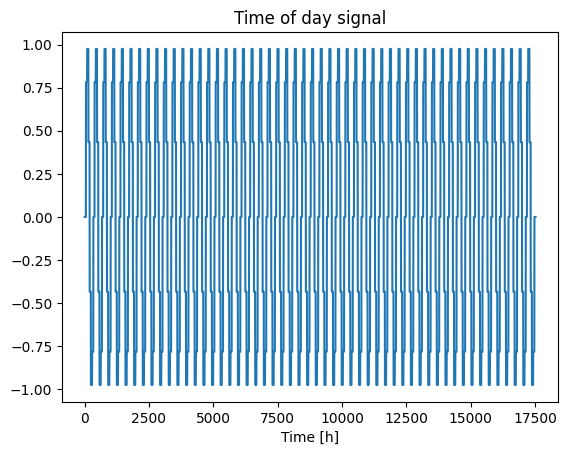

In [62]:
plt.plot(np.array(test))
plt.xlabel('Weeks')
plt.title('Time of day signal')

In [53]:
print(day_ids / 364)

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
17515    1.0
17516    1.0
17517    1.0
17518    1.0
17519    1.0
Name: row_id, Length: 17520, dtype: float64


In [23]:
date_time = pd.to_datetime(train_df_2020.pop('date'), format='%Y-%m-%d')

In [24]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [25]:
day = 24*60*60
year = (365.2425)*day

train_df_2020['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
train_df_2020['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
train_df_2020['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
train_df_2020['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

test_df_2020['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
test_df_2020['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
test_df_2020['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
test_df_2020['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [37]:
train_df_2020[(train_df_2020['product'] == 'Kaggle Advanced Techniques') & (train_df_2020['store'] == 'KaggleMart') & (train_df_2020['country'] == 'Belgium')].head(200)

,row_id,country,store,product,num_sold,Day sin,Day cos,Year sin,Year cos
52608,52608,Belgium,KaggleMart,Kaggle Advanced Techniques,452,-3.371804e-12,1.0,0.015052,0.999887
52656,52656,Belgium,KaggleMart,Kaggle Advanced Techniques,452,9.267350e-13,1.0,0.032250,0.999480
52704,52704,Belgium,KaggleMart,Kaggle Advanced Techniques,517,-9.326642e-12,1.0,0.049438,0.998777
52752,52752,Belgium,KaggleMart,Kaggle Advanced Techniques,503,-5.028103e-12,1.0,0.066611,0.997779
52800,52800,Belgium,KaggleMart,Kaggle Advanced Techniques,445,-7.295644e-13,1.0,0.083765,0.996486
...,...,...,...,...,...,...,...,...,...
62016,62016,Belgium,KaggleMart,Kaggle Advanced Techniques,311,-4.869317e-12,1.0,-0.242754,-0.970088
62064,62064,Belgium,KaggleMart,Kaggle Advanced Techniques,370,-5.707784e-13,1.0,-0.259406,-0.965768
62112,62112,Belgium,KaggleMart,Kaggle Advanced Techniques,390,-1.082415e-11,1.0,-0.275980,-0.961163
62160,62160,Belgium,KaggleMart,Kaggle Advanced Techniques,409,-6.525616e-12,1.0,-0.292473,-0.956274


Text(0.5, 1.0, 'Time of day signal')

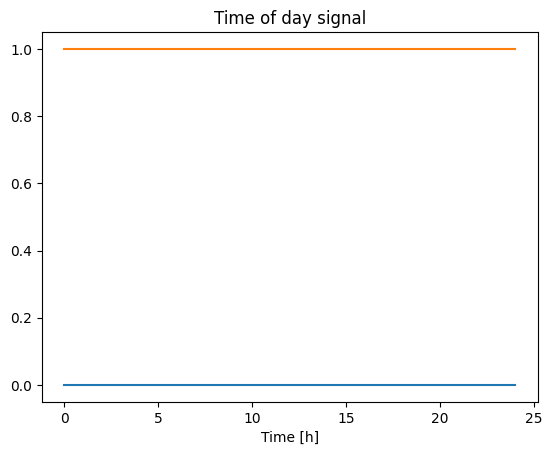

In [35]:

plt.plot(np.array(train_df_2020[(train_df_2020['product'] == 'Kaggle Advanced Techniques') & (train_df_2020['store'] == 'KaggleMart') & (train_df_2020['country'] == 'Belgium')]['Day sin'])[:25])
plt.plot(np.array(train_df_2020[(train_df_2020['product'] == 'Kaggle Advanced Techniques') & (train_df_2020['store'] == 'KaggleMart') & (train_df_2020['country'] == 'Belgium')]['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [ ]:
train_df_2020 = train_df[train_df["date"] > pd.Timestamp("2020-01-01")].copy(deep=True)
test_df_2020 = test_df[test_df["date"] > pd.Timestamp("2020-01-01")].copy(deep=True)